In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Preparing the Dataset


In [3]:
#Download data

dataset = MNIST(root = 'data/', download = True, transform = ToTensor())
test_dataset = MNIST(root = 'data/', train = False, transform = ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#Data separation for training and validation

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
#Load Dataset

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size * 2, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size * 2, num_workers = 2, pin_memory = True)

Image shape:  torch.Size([128, 1, 28, 28])


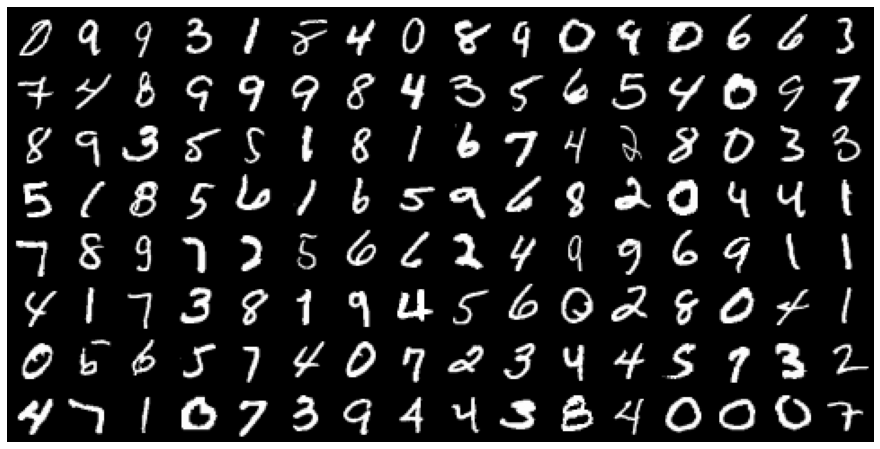

In [6]:
#Visualize a sample batch of data

for images, _ in train_loader:
  print('Image shape: ', images.shape)
  plt.figure(figsize = (16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16).permute((1, 2, 0)))
  break

Model Creation


In [7]:
#Define Accuracy

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds ==labels)/ len(preds))

In [23]:
#Model

class MnistModel(nn.Module):
  """FeedForward Neural Network with 1 hidden layer"""
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    #Hidden Layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    #Output Layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    #Flatten the image tensor
    xb = xb.view(xb.size(0), -1)
    #Get Intermediate output
    out = self.linear1(xb)
    #Apply Activation Function
    out = F.relu(out)
    #Get Prediction
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)                    #Generate Predictions
    loss = F.cross_entropy(out, labels)   #Calculate Loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                    #Generate Predictions
    loss = F.cross_entropy(out, labels)   #Calculate Loss
    acc = accuracy(out, labels)           #Calculate Accuracy
    return {'val_acc': acc, 'val_loss': loss}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     #Combine Losses (Average)
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        #Combine Accuracies (Average)
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Using GPU

In [24]:
#Check Availability

torch.cuda.is_available()

True

In [25]:
#Helper function to use GPU(if available) else use CPU

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [26]:
#Print Default Device
device = get_default_device()
device

device(type='cuda')

In [27]:
#Move data(tensor) to the default device

def to_device(data, device):
  """Move tensor to device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [28]:
#Create device dataloader

class DeviceDataLoader():
  """Wrap a dataloader to move data to device"""
  def __init__(self, dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of Batches"""
    return len(self.dl)

In [29]:
#Load the data from device

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Training the model

In [30]:
#Create evaluate function

def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

#Define Fit Function

def fit(epochs, lr, model, train_loader,val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  
  for epoch in range(epochs):
    #Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #Validation Phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [31]:
input_size = 784
hidden_size = 32
num_classes = 10

model = MnistModel(input_size, hidden_size, out_size = num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [32]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


[{'val_acc': 0.12568359076976776, 'val_loss': 2.3108508586883545}]

In [33]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Epoch [0], val_loss: 0.2521, val_acc: 0.9221
Epoch [1], val_loss: 0.1862, val_acc: 0.9418
Epoch [2], val_loss: 0.1476, val_acc: 0.9578
Epoch [3], val_loss: 0.1582, val_acc: 0.9505
Epoch [4], val_loss: 0.1420, val_acc: 0.9584


In [34]:
history += fit(5, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Epoch [0], val_loss: 0.1184, val_acc: 0.9638
Epoch [1], val_loss: 0.1184, val_acc: 0.9644
Epoch [2], val_loss: 0.1160, val_acc: 0.9639
Epoch [3], val_loss: 0.1159, val_acc: 0.9643
Epoch [4], val_loss: 0.1164, val_acc: 0.9658


In [35]:
history += fit(5, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Epoch [0], val_loss: 0.1146, val_acc: 0.9654
Epoch [1], val_loss: 0.1147, val_acc: 0.9651
Epoch [2], val_loss: 0.1143, val_acc: 0.9647
Epoch [3], val_loss: 0.1145, val_acc: 0.9650
Epoch [4], val_loss: 0.1145, val_acc: 0.9650


Ploting Training Progress

Text(0.5, 1.0, 'Loss Vs No. of epochs')

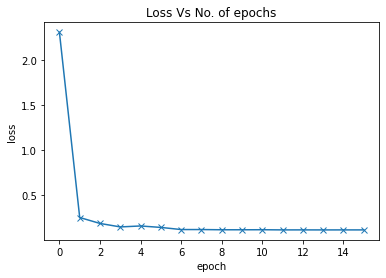

In [36]:
# Loss Vs Epoch Curve

losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Vs No. of epochs')

Text(0.5, 1.0, 'Accuracy Vs No. of epochs')

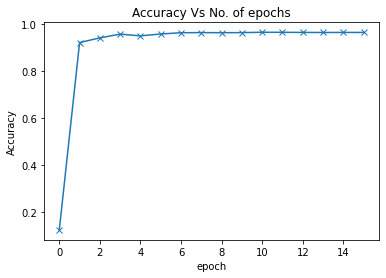

In [38]:
# Accuracy Vs Epoch Curve

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs No. of epochs')

Prediction on Samples

In [40]:
#Testing with Individual Image
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label:  8 - eight , Predicted:  8 - eight


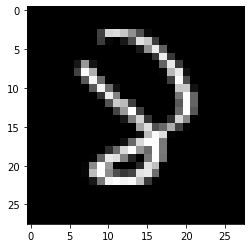

In [42]:
img, label = test_dataset[1364]
plt.imshow(img[0], cmap = 'gray')
print('Label: ', dataset.classes[label], ', Predicted: ', dataset.classes[predict_image(img, model)])

Accuracy on Test Data


In [44]:
result = evaluate(model, test_loader)
print('Test Accuracy: ', result['val_acc'], 'Test Loss: ', result['val_loss'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Test Accuracy:  0.969531238079071 Test Loss:  0.10091080516576767


Saving the Trained Model

In [45]:
torch.save(model.state_dict(), 'mnist_feedforward_gpu.pth')